In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 100

train_loader = DataLoader(dataset=cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=cifar10_test, batch_size=batch_size, shuffle=False)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


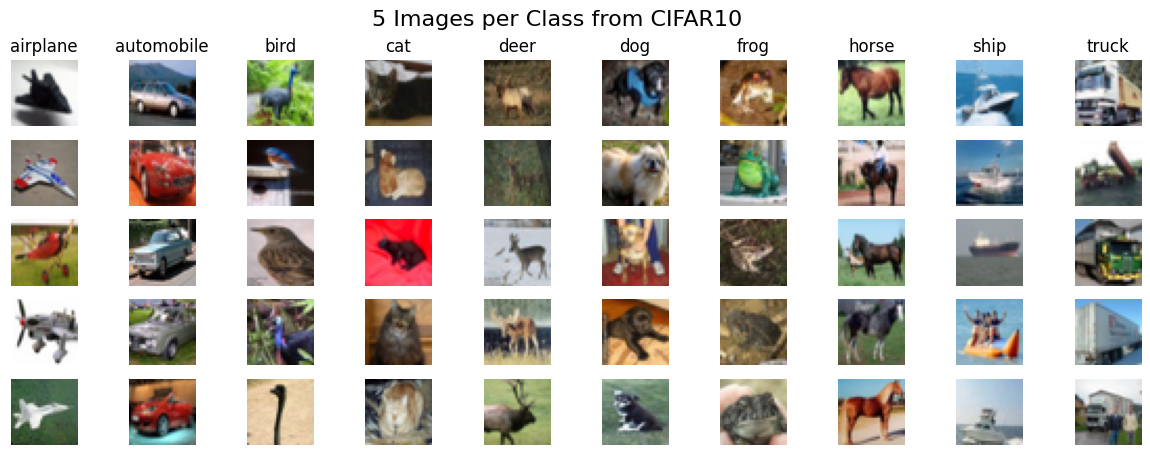

In [3]:
# Class labels in CIFAR10
class_labels = cifar10_train.classes

# Initialize a dictionary to hold 5 images for each class
images_per_class = {label: [] for label in class_labels}

# Collect 5 images per class
for img, label in cifar10_train:
    class_name = class_labels[label]
    if len(images_per_class[class_name]) < 5:
        images_per_class[class_name].append((img, label))
    if all(len(images) >= 5 for images in images_per_class.values()):
        break

# Plot the images
fig, axes = plt.subplots(5, len(class_labels), figsize=(15, 5))
fig.suptitle("5 Images per Class from CIFAR10", fontsize=16)

for row, (class_name, images) in enumerate(images_per_class.items()):
    for col, (img, label) in enumerate(images):
        axes[col, row].imshow(img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        axes[col, row].axis('off')
        if col == 0:
            axes[col, row].set_title(class_name, fontsize=12)

plt.show()

## VAE 1

In [12]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (256, 2, 2)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()  # Flatten the output
        )
        self.fc_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(256 * 2 * 2, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # (3, 32, 32)
            nn.Sigmoid()  # CIFAR-10 images are normalized between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z).view(-1, 256, 2, 2)
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [13]:
latent_dim = 128
model = ConvVAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
model

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=1024, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=128, bias=True)
  (decoder_input): Linear(in_features=128, out_features=102

In [18]:
# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    """Combines reconstruction loss and KL divergence."""
    recon_loss = nn.MSELoss()(recon_x, x)  # Reconstruction loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)  # KL divergence
    return recon_loss + kld_loss

In [19]:
# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

print("Training Complete.")

Epoch 1, Loss: 0.0027
Epoch 2, Loss: 0.0007
Epoch 3, Loss: 0.0007
Epoch 4, Loss: 0.0007
Epoch 5, Loss: 0.0007
Epoch 6, Loss: 0.0007
Epoch 7, Loss: 0.0007
Epoch 8, Loss: 0.0006
Epoch 9, Loss: 0.0006
Epoch 10, Loss: 0.0006
Training Complete.


In [20]:
# Visualization Helper
def visualize_images(images, title="Images"):
    images = np.transpose(images, (0, 2, 3, 1))  # Convert to (batch_size, H, W, C)
    images = (images * 0.5 + 0.5).clip(0, 1)  # Denormalize the images
    
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(2, len(images) // 2, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [21]:
# Inference Function
def inference(model, device, test_loader, num_images=8, latent_dim=128, generate_new=False):
    model.eval()  # Set the model to evaluation mode
    
    if generate_new:
        # Generate new images by sampling random latent vectors
        with torch.no_grad():
            z = torch.randn(num_images, latent_dim).to(device)  # Sample random latent vectors
            generated_images = model.decode(z).cpu().numpy()
            visualize_images(generated_images, title="Generated Images")
    else:
        # Reconstruct images from the test set
        with torch.no_grad():
            data_iter = iter(test_loader)
            images, _ = next(data_iter)
            images = images[:num_images].to(device)
            reconstructed, _, _ = model(images)
            visualize_images(images.cpu().numpy(), title="Original Images")
            visualize_images(reconstructed.cpu().numpy(), title="Reconstructed Images")




Reconstructing images from test set...


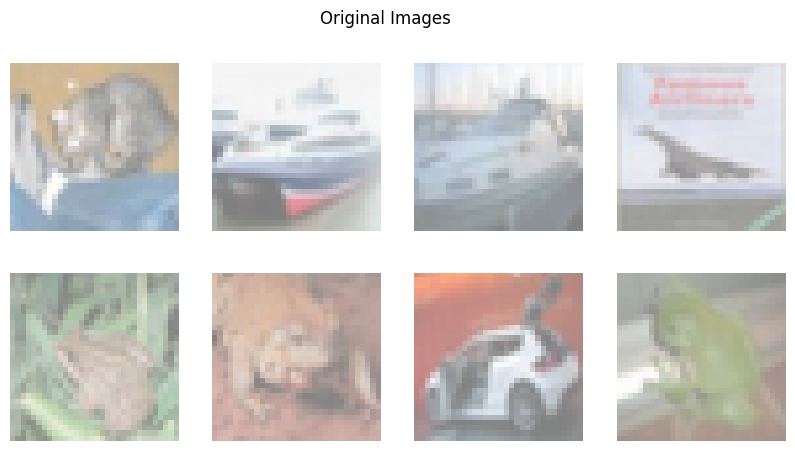

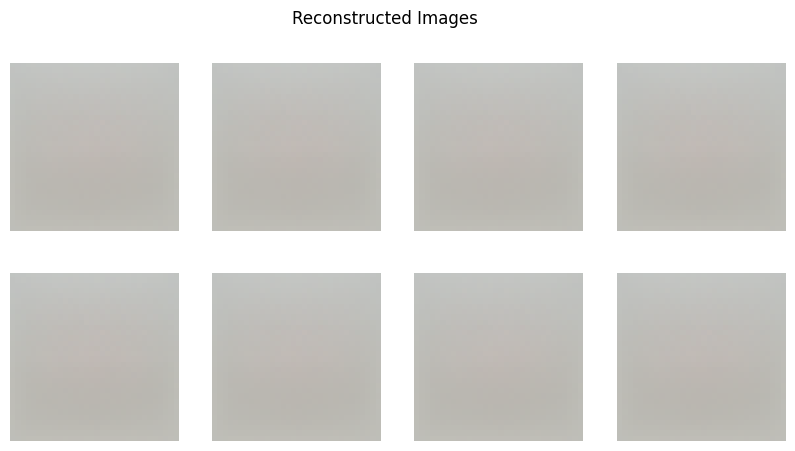

In [22]:
print("Reconstructing images from test set...")
inference(model, device, test_loader, num_images=8, generate_new=False)


Generating new images...


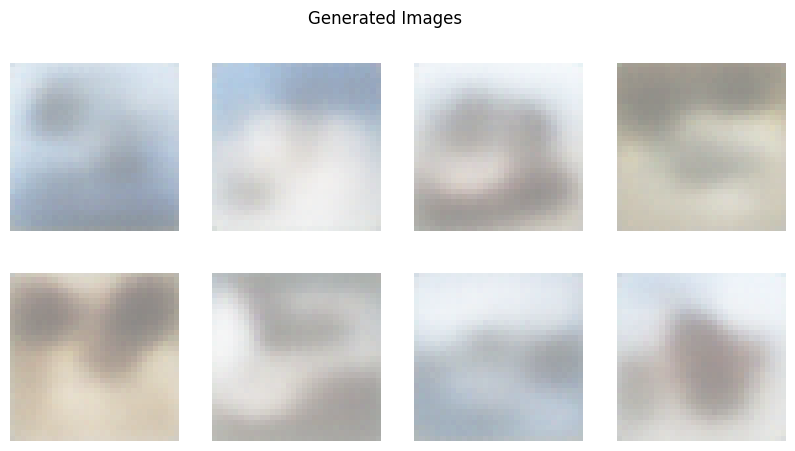

In [38]:
print("Generating new images...")
inference(model, device, test_loader, num_images=8, generate_new=True)

## VAE 3

In [4]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(8192, latent_dim)  # Adjusted for correct input size
        self.fc_logvar = nn.Linear(8192, latent_dim)  # Adjusted for correct input size

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 8192)  # Adjusted for correct output size
        self.decoder = nn.Sequential(
            Reshape(128, 8, 8),  # Ensure correct 4D shape
            nn.ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Sigmoid()  # Normalize output to [0, 1]
        )

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample z ~ N(mu, sigma^2)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decode
        x_recon = self.decoder(self.decoder_input(z))
        return x_recon, mu, logvar



In [5]:

# Instantiate the model and optimizer
latent_dim = 128
model = VAE(latent_dim=latent_dim).to(device)
LEARNING_RATE = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [6]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=8192, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=81

In [7]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [8]:
# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

print("Training Complete.")

Epoch 1, Loss: 0.0607
Epoch 2, Loss: 0.0008
Epoch 3, Loss: 0.0010
Epoch 4, Loss: 0.0011
Epoch 5, Loss: 0.0012
Training Complete.


In [9]:
# Visualization Helper
def visualize_images(images, title="Images"):
    images = np.transpose(images, (0, 2, 3, 1))  # Convert to (batch_size, H, W, C)
    images = (images * 0.5 + 0.5).clip(0, 1)  # Denormalize the images
    
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(2, len(images) // 2, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [10]:
# Inference Function
def inference(model, device, test_loader, num_images=8, latent_dim=128, generate_new=False):
    model.eval()  # Set the model to evaluation mode
    
    if generate_new:
        # Generate new images by sampling random latent vectors
        with torch.no_grad():
            z = torch.randn(num_images, latent_dim).to(device)  # Sample random latent vectors
            generated_images = model.decode(z).cpu().numpy()
            visualize_images(generated_images, title="Generated Images")
    else:
        # Reconstruct images from the test set
        with torch.no_grad():
            data_iter = iter(test_loader)
            images, _ = next(data_iter)
            images = images[:num_images].to(device)
            reconstructed, _, _ = model(images)
            visualize_images(images.cpu().numpy(), title="Original Images")
            visualize_images(reconstructed.cpu().numpy(), title="Reconstructed Images")




Reconstructing images from test set...


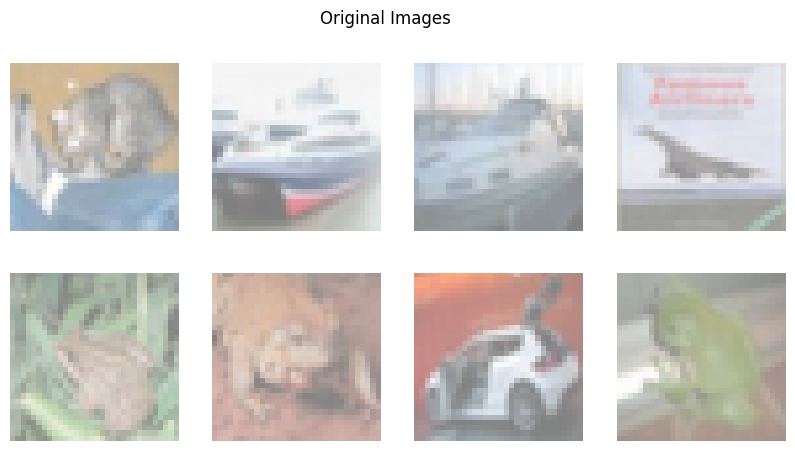

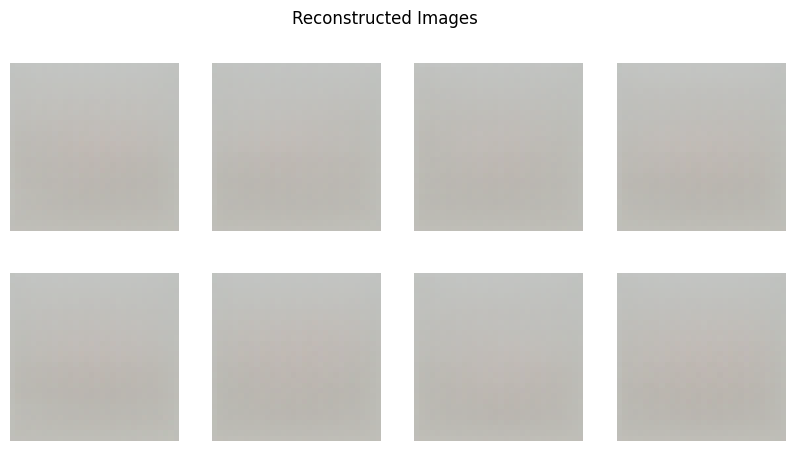

In [11]:
print("Reconstructing images from test set...")
inference(model, device, test_loader, num_images=8, generate_new=False)
